Now we will train the Particle Sequence classifier.

To run this notebook we used the following configuration:
* *Software stack*: LCG 94 (it has spark 2.3.1)
* *Platform*: centos7-gcc7
* *Spark cluster*: Hadalytic

In [20]:
# Check if Spark Session has been created correctly
spark

In [21]:
# Add the BDL zip file
# sc.addPyFile("/eos/project/s/swan/public/BigDL/bigdl-0.7.0-python-api.zip")

## Load train and test dataset

In [22]:
PATH = "file:///data/cern/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['GRU_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['GRU_input', 'encoded_label'])

In [23]:
trainDF.printSchema()

root
 |-- GRU_input: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- encoded_label: vector (nullable = true)



## Create the model

In [24]:
# Start BigDL
from bigdl.util.common import init_engine
init_engine()

In [25]:
from bigdl.nn.layer import *

recurrent = Recurrent()
recurrent.add(
    GRU(
        input_size=19,
         hidden_size=50,
        activation='tanh'
        )
)

model = Sequential()
model.add(Masking(0.0))
model.add(recurrent)
model.add(Select(2,-1))
model.add(BatchNormalization(50))
model.add(Linear(50,3))
model.add(SoftMax())

creating: createRecurrent
creating: createSigmoid
creating: createTanh
creating: createGRU
creating: createSequential
creating: createMasking
creating: createSelect
creating: createBatchNormalization
creating: createLinear
creating: createSoftMax


## Create train and valiation RDD

We need to create an RDD of `Sample`, a tuple of the form (`features`, `label`). The two elements of this touple should be `numpy arrays`. 

In [26]:
from bigdl.util.common import Sample
import numpy as np

trainRDD = trainDF.rdd.map(lambda row: Sample.from_ndarray(
    np.array(row.GRU_input),
    np.array(row.encoded_label)
))

testRDD = testDF.rdd.map(lambda row: Sample.from_ndarray(
    np.array(row.GRU_input),
    np.array(row.encoded_label)
))

In [27]:
# Let's have a look at one element of trainRDD
trainRDD.take(1)

[Sample: features: [JTensor: storage: [ 4.4452043  -1.4459659   0.12834984 ...  0.         28.284271
  -2.0649471 ], shape: [801  19], float], labels: [JTensor: storage: [1. 0. 0.], shape: [3], float]]

We can see that `Sample` is composed by the list of 801 particles with 19 features each (`shape=[801 19]`) and the encoded label (`shape=[3]`).

## Optimizer setup and training

In [28]:
# Set of hyperparameters
numEpochs = 50

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 64
# numExecutors = int(sc._conf.get('spark.executor.instances'))
# executorCores = int(sc._conf.get('spark.executor.cores'))
numExecutors = 1
# executorCores = int(sc._conf.get('spark.executor.cores'))
executorCores = 4

BDLbatch = workerBatch * numExecutors * executorCores

In [29]:
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import CategoricalCrossEntropy

optimizer = Optimizer(
        model = model,
        training_rdd = trainRDD,
        criterion = CategoricalCrossEntropy(),
        optim_method = Adam(),
        end_trigger = MaxEpoch(numEpochs),
        batch_size = BDLbatch   
)

# Optionally you can also set validation
optimizer.set_validation(
    batch_size=BDLbatch,
    val_rdd=testRDD,
    trigger=EveryEpoch(),
    val_method=[Loss(CategoricalCrossEntropy())]
)

creating: createCategoricalCrossEntropy
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createCategoricalCrossEntropy
creating: createLoss


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [30]:
# name of our application
appName = "ParticleSequenceClassifier"

# Change it! 
logDir = "/data/cern/ZOOlogs"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /data/cern/BDLlogs/ParticleSequenceClassifier


In [31]:
trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
optimizer.set_train_summary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
optimizer.set_val_summary(valSummary)

creating: createTrainSummary
creating: createValidationSummary


We are now ready to launch the training.

Warnign: During the trainign it would be better to shutdown the Toggle Spark Monitorin Display because each iteration is seen as a spark job, therefore the toggle will try to display everything causing problem to the browser. 

In [32]:
%%time 
trained_model = optimizer.optimize()

KeyboardInterrupt: 

## Plot loss

<IPython.core.display.Javascript object>


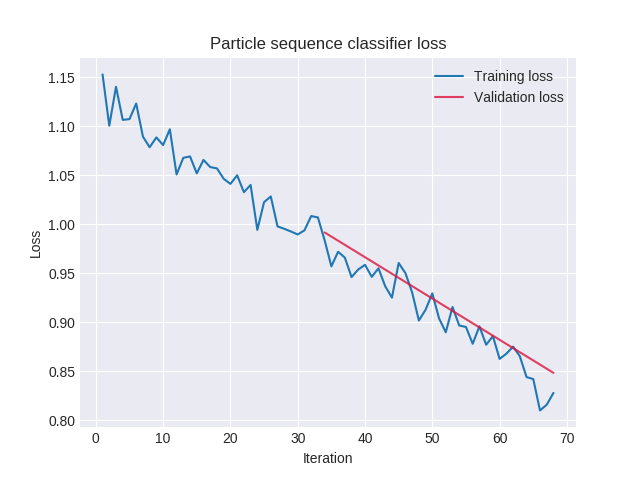

In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("Particle sequence classifier loss")
plt.show()

## Save the model

In [15]:
modelDir = logDir + '/models'
trained_model.saveModel(
            modelPath = modelDir + '/' + appName + '.bigdl',
            weightPath = modelDir + '/' + appName + '.bin',
            over_write = True
)

It is possible to load the model in the following way:
```Python
model = Model.loadModel(modelPath=modelPath+'.bigdl', weightPath=modelPath+'.bin')
```

## Prediction

In [16]:
pred = trained_model.predict(testRDD)

In [17]:
y_pred = np.asarray(pred.collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [18]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


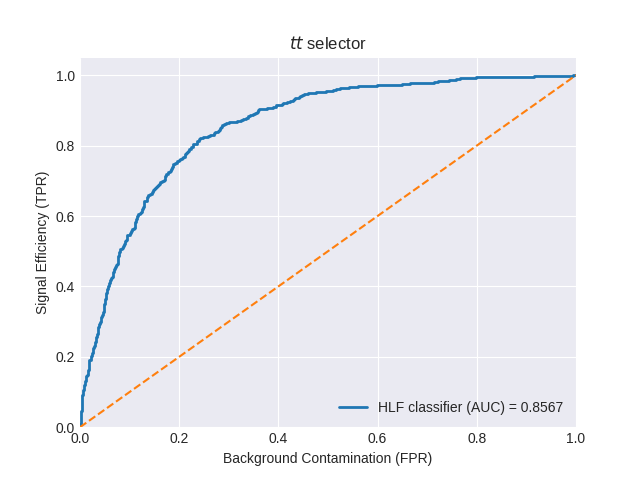

In [19]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()